In [2]:
# Importing libraries necessary for EDA (Exploratory Data Analysis)
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
#importing models from scikit learn 
from sklearn.svm import SVC #Support Vector Machine
from xgboost import XGBClassifier #XGBoost
from imblearn.over_sampling import SMOTE #SMOTE for oversampling unbalanced data 
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Importing hypertuning libraries
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, cross_val_score, StratifiedKFold
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
import joblib

## 1. Data Loading 

In [ ]:
# Using pandas read_csv() function to read the csv file and the head function to take a look at the first 5 rows of the dataset
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

* The dataset is composed of **9 columns and 768 rows**.

The next step is to take a look at the validity of the dataset. I will check for null values and impute using mean or median as per the distribution of the data for any null values.

In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

* There are no null values in the dataset. 

In [6]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

The target variable being predicted is the **Outcome** column (also known as **Y or dependent variable**). 

The values are imbalanced which is common in classification problems that deal with events that are rare, some examples of this: 

* Fraud Detection
* Medical Diagnosis
* Natural disaster prediction

This is an issue as models tend to favor the majority class as it minimizes overall error. This results in poor generalization for the minority class. Rare but important cases are missed by the model because it wants to keep accuracy score high and predictiing wrong would cause that score to fall. This imbalance will be handled in the Data Preprocessing phase.


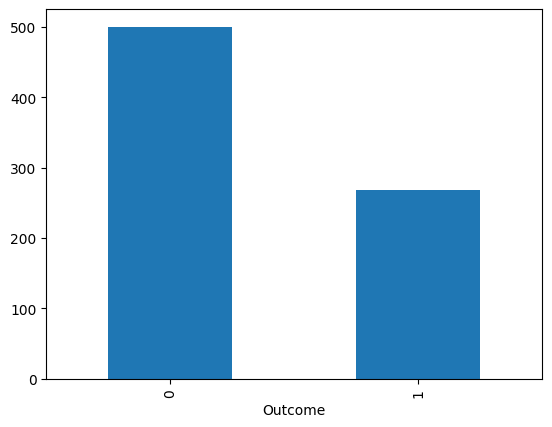

In [7]:
df['Outcome'].value_counts().plot(kind = 'bar')
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* The data is composed of all numerical values with the rows being in either an `int64` or `float64 `data type.
I will take a look at some summary statitics for the data to see if there are any irregularities.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


* One thing that jumps out at me is the standard deviation valie for the `Insulin` column. The average value is **79.80 while the deviation is 115.2**. 
* The `skin thickness` is another variable where the deviation is a little too close to the mean.

* I also see some records with 0 values when there shouldn't be such as **BMI, Insulin, Glucose and Blood Pressure**.


The next step of the EDA process would be to plot boxplots to look at the Outliars in the dataset as well as invetigate the value distribution of each of our inependent variables.



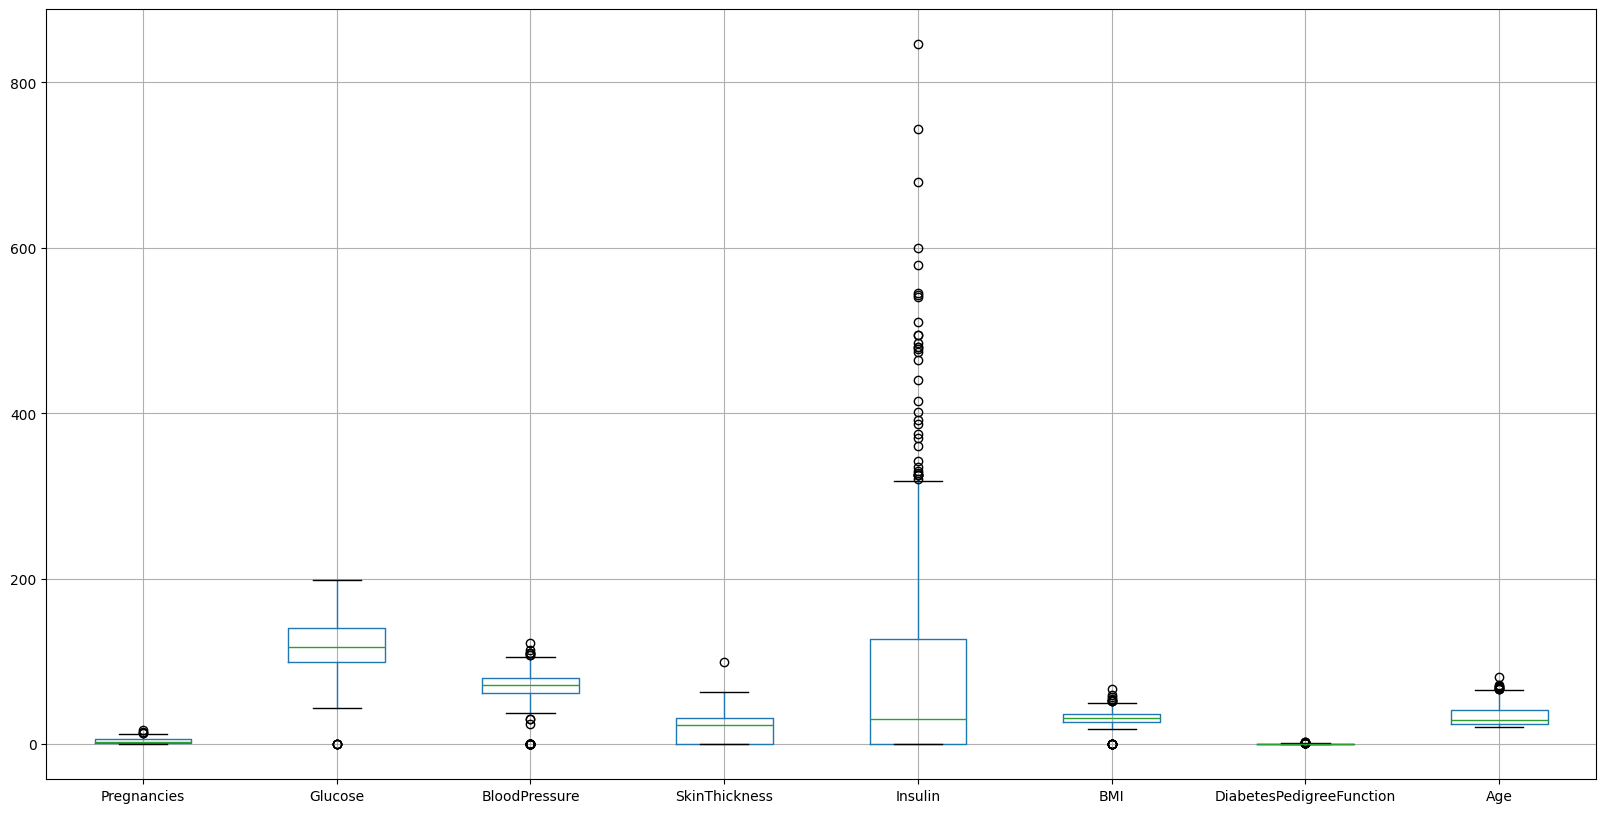

In [10]:
df.iloc[:, : (df.shape[1]-1)].boxplot(figsize=(20,10)) # Taking out the Dependent variable column 'Outcomes'
plt.show()

* Our initial hunch about the **Insulin** column deviation was correct as we can observe many outliers as per the boxplot above. Surprisingly there was alot of outliars observed for other variables as well.
* There were also many independent variables with a good amount of outliars observed such as: **Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Age**.
* There were also many zero values for independent variables where there shouldn't be such as: **Insulin, BMI, Blood Pressure**.

I will then recheck for outliers and construct a function to remove any of the remaining outliers prior to continuing with the Data precprocessing stage.


In [11]:
for col in df.columns[:-1]:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    df[col] = df[col].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
df.isnull().sum()
# The values of outliers for each column in the dataset can be seen in the value counts below

Pregnancies                  4
Glucose                      5
BloodPressure               45
SkinThickness                1
Insulin                     34
BMI                         19
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
dtype: int64

In [12]:
df.fillna(df.median(), inplace=True)
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

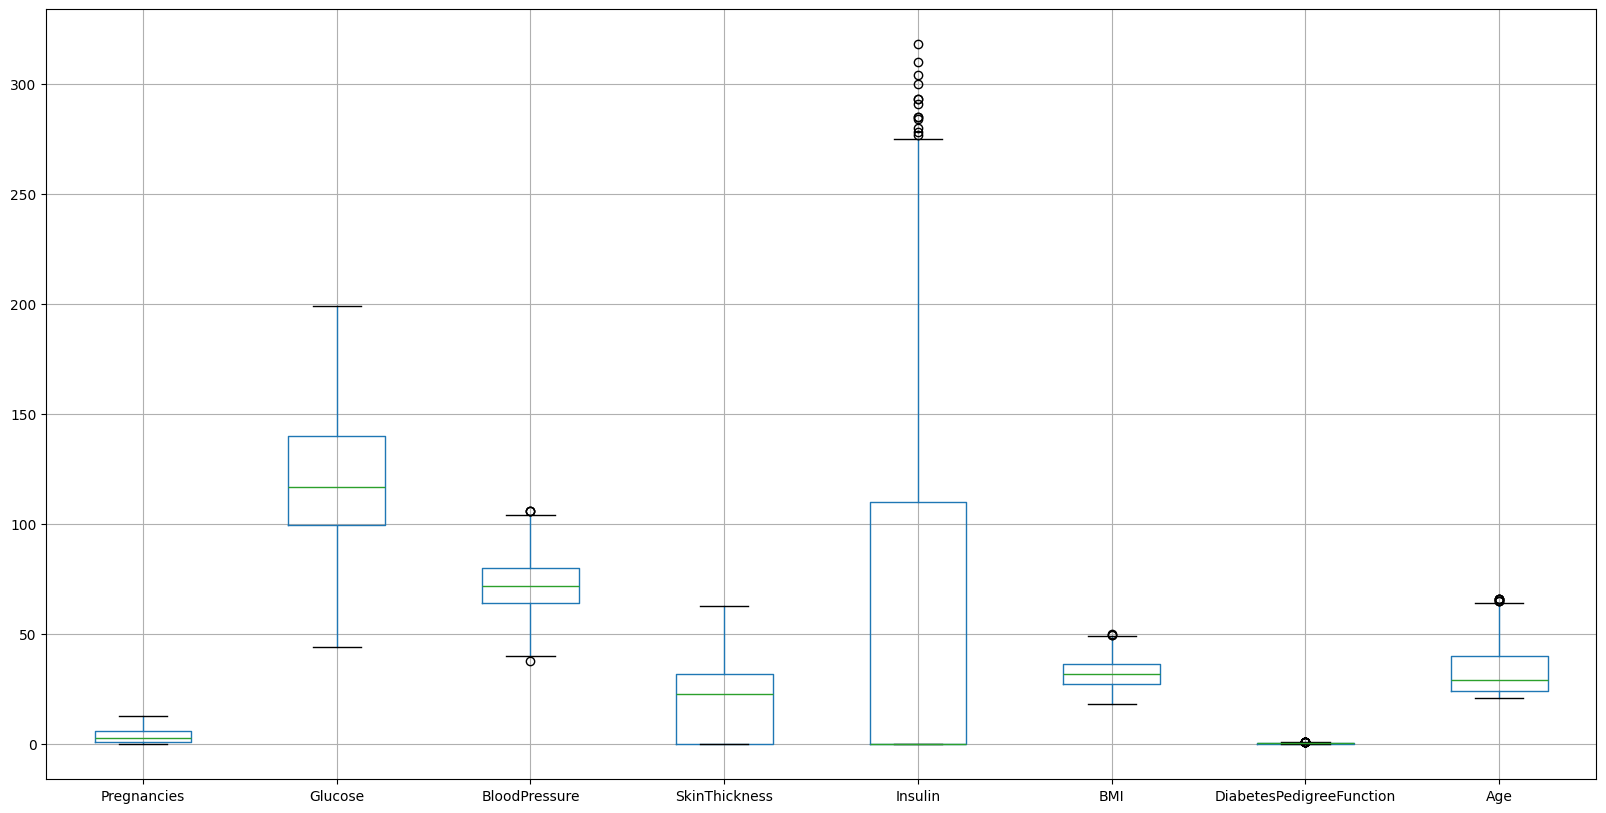

In [13]:
df.iloc[:, : (df.shape[1]-1)].boxplot(figsize=(20,10)) # Taking out the Dependent variable column 'Outcomes'
plt.show()

* As observed from the cells above the amount of outliers in the dataset has decreased significantly. 
* **Median imputation** was selected as its is a more centrail measure meaning it is likely to affect the mean.
* Another things that still jumps at me is the 0 values for the Insulin feature this will be handled in the next cell. 




In [29]:
df.loc[df['Insulin'] == 0, 'Insulin'] = np.nan
df['Insulin'].fillna(df['Insulin'].median(), inplace=True)
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

The heatmap showing the correlation between the cleaned models is to be plotted next: 

<Axes: >

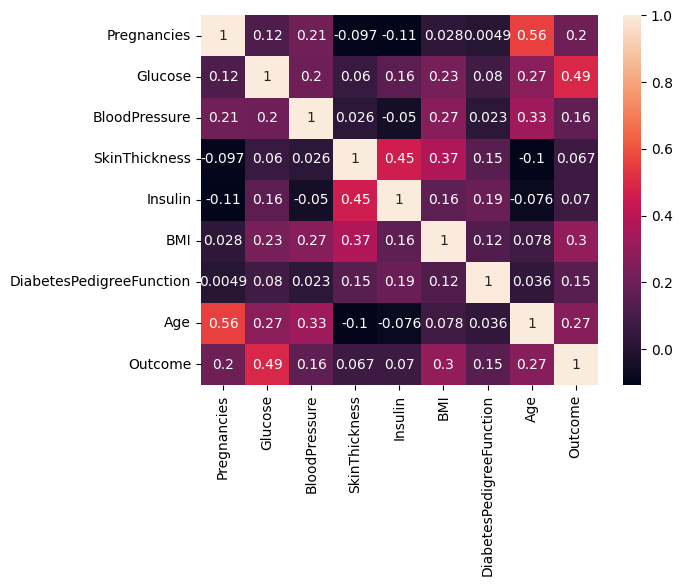

In [14]:
sns.heatmap(df.corr(), annot = True)

* The independent factor with the greatest correlation coefficient with the target variable is glucose with Pearson coefficient factor of 0.49 (Weak to Moderate Correlation).

Up next will be the balancing out the Target variable (Outcome). There are many ways to do this depending on the size of the dataset and the amount of the major and minor outcome labels. In our case it 500 to 276 so not too bad. 

There are two possible resampling tehcniques each with their own pros and cons. 
1. Oversampling the minority class 
2. Undersampling the Majority class (the dataset is not large to enough at 768 records to do this and still get a proper model built).

The method that is going to be applied will be **"Oversampling the minority class"**; more specifically **SMOTE (Synthetic Minority Oversampling Technique)**: Which is a method of oversampling that generates synthetic samples by interpolating between existing minority class samples as opposed to **Random Oversampling** which duplilcates examples from the minority class to balance out the data.

### Seperating Features and Target Variable

In [ ]:
#Seperating features and target variable
X = df.drop('Outcome', axis = 1)
y = df['Outcome']


In [31]:
df_cleaned = df.copy()
df_cleaned.describe().T



,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.782552,3.270644,0.000,1.00000,3.000,6.00000,13.000
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.000,140.25000,199.000
BloodPressure,768.0,72.196615,11.146723,38.000,64.00000,72.000,80.00000,106.000
SkinThickness,768.0,20.437500,15.698554,0.000,0.00000,23.000,32.00000,63.000
Insulin,768.0,120.662760,46.459802,14.000,115.00000,115.000,115.00000,318.000
BMI,768.0,32.198958,6.410558,18.200,27.50000,32.000,36.30000,50.000
DiabetesPedigreeFunction,768.0,0.427044,0.245323,0.078,0.24375,0.356,0.58225,1.191
Age,768.0,32.760417,11.055385,21.000,24.00000,29.000,40.00000,66.000
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.000,1.00000,1.000


* Some notes about the next section of my analysis. The scaling, SMOTE oversampling will be done in the `for loops` iterating over random states and taking the mean of the 50 samples.
* The scaling and SMOTE oversampling were only carried out on the training data as to avoid data leakage. (An earlier version of this notebook had them run on the entire dataset resulting in a severe raise in the models.)

## 3. Model Selection 

The following models will be compared to see which predicts the test data with the highest accuracy. 
1. Random Forrest Classifier 
2. SVM (Support Vector Machine) Algorithms 
3. XGBoostClassifier Model
4. Extra Trees Classifier 
5. Ada Boost Classifier

#1. Random Forest Classifier

The average accuracy of random forest classifier is 0.7614285714285712
The shape of the resampled test data was (800, 8)


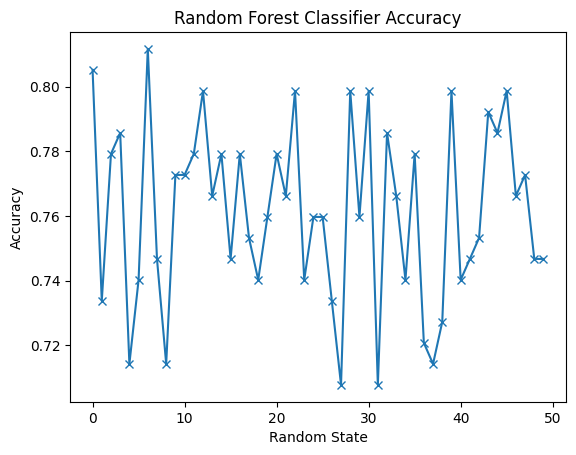

In [16]:
n = 50 
random_state = []
forest_accuracy = []
for i in range(n): 
    random_state.append(i)
    #Splitting the dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i, stratify = y)
    #Applying SMOTE to balance the dataset only on training set to avoid data leak
    smote = SMOTE(random_state = i)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)
    #Scaling the dataset only on training data to avoid data leak 
    scaler = StandardScaler()
    X_train_resampled= scaler.fit_transform(X_train_resampled)
    X_test = scaler.transform(X_test)
    #Fitting the model on scaled data set   
    rfc = RandomForestClassifier(random_state=i)
    rfc.fit(X_train_resampled, y_train_resampled)
    y_pred = rfc.predict(X_test)
    forest_accuracy.append(accuracy_score(y_test, y_pred))

print(f"The average accuracy of random forest classifier is {np.mean(forest_accuracy)}")
print("The shape of the resampled test data was", X_train_resampled.shape)

plt.plot(random_state, forest_accuracy, marker = 'x')
plt.xlabel('Random State') 
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Accuracy')
plt.show()



#2. Support Vector Classifier

The average accuracy of supportvector classifier is 0.7532467532467532
The shape of the resampled test data was (800, 8)


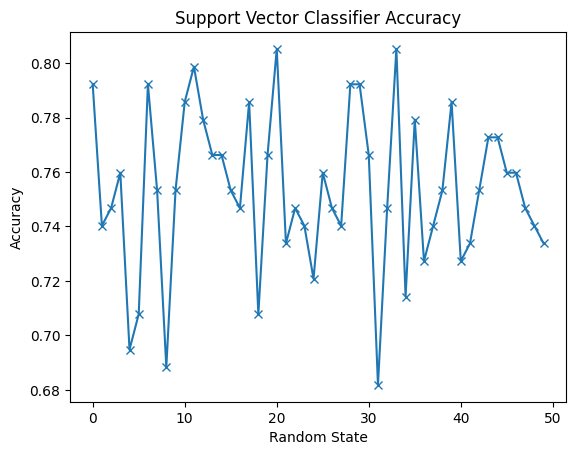

In [17]:
n = 50 
random_state = []
svm_accuracy = []
for i in range(n): 
    random_state.append(i)
    #Splitting the dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i, stratify = y)
    #Applying SMOTE to balance the dataset only on training set to avoid data leak
    smote = SMOTE(random_state = i)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)
    #Scaling the dataset only on training data to avoid data leak 
    scaler = StandardScaler()
    X_train_resampled= scaler.fit_transform(X_train_resampled)
    X_test = scaler.transform(X_test)
    #Fitting the model on scaled data set   
    svm = SVC(random_state=i)
    svm.fit(X_train_resampled, y_train_resampled)
    y_pred = svm.predict(X_test)
    svm_accuracy.append(accuracy_score(y_test, y_pred))

print(f"The average accuracy of supportvector classifier is {np.mean(svm_accuracy)}")
print("The shape of the resampled test data was", X_train_resampled.shape)

plt.plot(random_state, svm_accuracy, marker = 'x')
plt.xlabel('Random State') 
plt.ylabel('Accuracy')
plt.title('Support Vector Classifier Accuracy')
plt.show()

The average accuracy of supportvector classifier is 0.7363636363636364
The shape of the resampled test data was (800, 8)


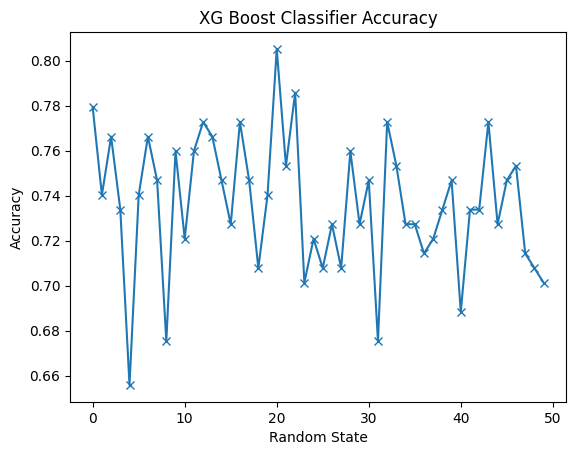

In [18]:
n = 50 
random_state = []
xgb_accuracy = []
for i in range(n): 
    random_state.append(i)
    #Splitting the dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i, stratify = y)
    #Applying SMOTE to balance the dataset only on training set to avoid data leak
    smote = SMOTE(random_state = i)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)
    #Scaling the dataset only on training data to avoid data leak 
    scaler = StandardScaler()
    X_train_resampled= scaler.fit_transform(X_train_resampled)
    X_test = scaler.transform(X_test)
    #Fitting the model on scaled data set   
    xgb = XGBClassifier(random_state=i)
    xgb.fit(X_train_resampled, y_train_resampled)
    y_pred = xgb.predict(X_test)
    xgb_accuracy.append(accuracy_score(y_test, y_pred))

print(f"The average accuracy of supportvector classifier is {np.mean(xgb_accuracy)}")
print("The shape of the resampled test data was", X_train_resampled.shape)

plt.plot(random_state, xgb_accuracy, marker = 'x')
plt.xlabel('Random State') 
plt.ylabel('Accuracy')
plt.title('XG Boost Classifier Accuracy')
plt.show()

The average accuracy of ETC classifier is 0.7575324675324674
The shape of the resampled test data was (800, 8)


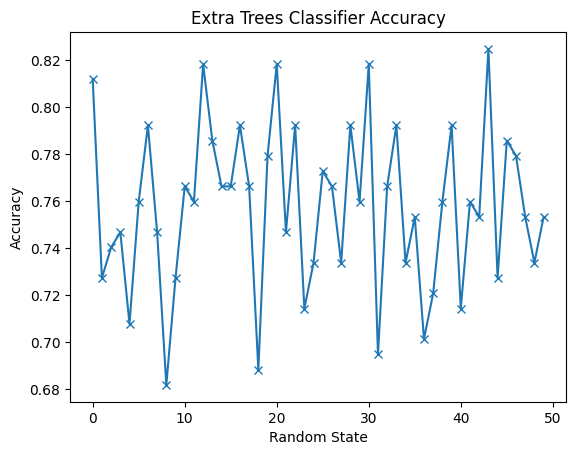

In [19]:
from sklearn.ensemble import ExtraTreesClassifier
n = 50 
random_state = []
xtr_accuracy = []
for i in range(n): 
    random_state.append(i)
    #Splitting the dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i, stratify = y)
    #Applying SMOTE to balance the dataset only on training set to avoid data leak
    smote = SMOTE(random_state = i)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)
    #Scaling the dataset only on training data to avoid data leak 
    scaler = StandardScaler()
    X_train_resampled= scaler.fit_transform(X_train_resampled)
    X_test = scaler.transform(X_test)
    #Fitting the model on scaled data set   
    xtr = ExtraTreesClassifier(random_state=i)
    xtr.fit(X_train_resampled, y_train_resampled)
    y_pred = xtr.predict(X_test)
    xtr_accuracy.append(accuracy_score(y_test, y_pred))

print(f"The average accuracy of ETC classifier is {np.mean(xtr_accuracy)}")
print("The shape of the resampled test data was", X_train_resampled.shape)

plt.plot(random_state, xtr_accuracy, marker = 'x')
plt.xlabel('Random State') 
plt.ylabel('Accuracy')
plt.title('Extra Trees Classifier Accuracy')
plt.show()

The average accuracy of ETC classifier is 0.7511688311688312
The shape of the resampled test data was (800, 8)


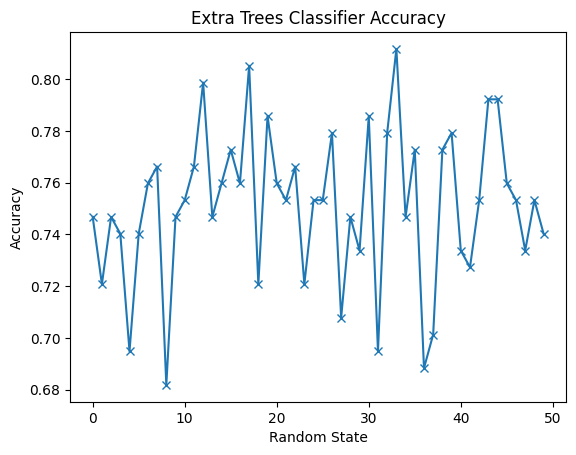

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

n = 50 
random_state = []
ada_accuracy = []
for i in range(n): 
    random_state.append(i)
    #Splitting the dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i, stratify = y)
    #Applying SMOTE to balance the dataset only on training set to avoid data leak
    smote = SMOTE(random_state = i)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)
    #Scaling the dataset only on training data to avoid data leak 
    scaler = StandardScaler()
    X_train_resampled= scaler.fit_transform(X_train_resampled)
    X_test = scaler.transform(X_test)
    #Fitting the model on scaled data set   
    ada = AdaBoostClassifier(random_state=i)
    ada.fit(X_train_resampled, y_train_resampled)
    y_pred = ada.predict(X_test)
    ada_accuracy.append(accuracy_score(y_test, y_pred))

print(f"The average accuracy of AdaBoost classifier is {np.mean(ada_accuracy)}")
print("The shape of the resampled test data was", X_train_resampled.shape)

plt.plot(random_state, ada_accuracy, marker = 'x')
plt.xlabel('Random State') 
plt.ylabel('Accuracy')
plt.title('Ada Boost Classifier Accuracy')
plt.show()

* A brief summary of the models and the mean accuracy noted. 

| Model                          | Mean Accuracy  | 
|--------------------------------|----------|
|  1.Random Forest  | 76.1% | 
|  2.SVC   |75.3%  | 
|  3.XGB    |73.6%|
|  4.Extra Trees Classifier    |75.7%|
|  5.Ada Boost Classifier    |75.1%|

# Hyperparameter Optimization
The next step would be hyperparameter optimization with the model with the highest mean accuracy; in this case Random Forest Classifier (RFC). 
This is done below: 


In [20]:
from scipy.stats import randint
# Tuning the hyperparameters of the Random Forest Classifier
param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [20, 30, 40, 50, 80, None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

#create the the RFC model
model = RandomForestClassifier()

#create a gridsearchCV of the model 
rfc =RandomizedSearchCV(model, param_distributions = param_grid, refit = True, verbose = 2, cv = 5, n_jobs= -1, scoring = 'accuracy', n_iter= 75)

#fit the model 
rfc.fit(X_train_resampled, y_train_resampled)
#use the ebst model for predictions
y_pred = rfc.predict(X_test)
#evaluate the model 
print("Final Accuracy score of RFC", accuracy_score(y_test, y_pred))
print("-" * 27)
print("Best Parameters of RFC", rfc.best_params_)
print("The mean accuracy of the model is", np.mean(rfc.cv_results_['mean_test_score']))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Final Accuracy score of RFC 0.7727272727272727
---------------------------
Best Parameters of RFC {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 800}
The mean accuracy of the model is nan


The RFC model after being having hyperparameter tuning resulted in an accuracy score of 77.3 %. This is only 1.3% higher than the base parameters. I will reattempt hyperparameter tuning utilizing **Optuna** which utilizes Bayesian optimization. 

In [ ]:
import optuna
def objective(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 200, 2000),
        "criterion": trial.suggest_categorical('criterion', ['gini', 'entropy']),
        "max_features" : trial.suggest_categorical('max_features', ['sqrt', 'log2']),
       "max_depth" : trial.suggest_int('max_depth', 20, 80),
        "min_samples_split" : trial.suggest_int('min_samples_split', 2, 11),
        "min_samples_leaf" : trial.suggest_int('min_samples_leaf', 1, 5)
    }
    
    rfc = RandomForestClassifier(**params)
    score = cross_val_score(rfc, X_train_resampled, y_train_resampled, n_jobs = -1, cv = 5, scoring = 'accuracy').mean()
    return score
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
print("Best parameters", study.best_params)
print("Best score", study.best_value)


[I 2025-03-12 01:01:08,874] A new study created in memory with name: no-name-d8a58ce8-37db-4cc9-a89f-41cb41acf65f
[I 2025-03-12 01:01:13,896] Trial 0 finished with value: 0.8150000000000001 and parameters: {'n_estimators': 1931, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8150000000000001.
[I 2025-03-12 01:01:16,896] Trial 1 finished with value: 0.8125 and parameters: {'n_estimators': 1374, 'criterion': 'gini', 'max_features': 'log2', 'max_depth': 69, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8150000000000001.
[I 2025-03-12 01:01:18,408] Trial 2 finished with value: 0.8125 and parameters: {'n_estimators': 705, 'criterion': 'gini', 'max_features': 'log2', 'max_depth': 64, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8150000000000001.
[I 2025-03-12 01:01:22,011] Trial 3 finished with value: 0.8099999999999999 and parameter

Best parameters {'n_estimators': 902, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best score 0.83125


* The utilization of Optuna resulted in an accuracy score of 83.13% a 7% increase. 
* **Ada Boost Classifier** was the second most accurate model. I will attempt hyperparameter optimization using Optuna and **Extra Trees Classifier** as the base estimator. 

In [22]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1),
        'max_depth': trial.suggest_int('max_depth', 20, 100), 
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }
    
    # Define base estimator with max_depth
    estimator = ExtraTreesClassifier(max_depth=params['max_depth'],
                                      criterion=params['criterion'],
                             max_features=params['max_features'], 
                            )

    # AdaBoost Classifier
    abc = AdaBoostClassifier(estimator=estimator,  # ✅ Fixed parameter name
                             n_estimators=params['n_estimators'], 
                             learning_rate=params['learning_rate'])

    # Cross-validation score
    score = cross_val_score(abc, X_train_resampled, y_train_resampled,n_jobs = -1, cv=5, scoring='accuracy').mean()
    return score
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, n_jobs = -1)
print("Best parameters", study.best_params)
print("Best score", study.best_value)




[I 2025-03-12 01:06:33,461] A new study created in memory with name: no-name-03a90b75-7a5b-425e-a6bc-28a27b54d786
[I 2025-03-12 01:06:34,108] Trial 0 finished with value: 0.8137500000000001 and parameters: {'n_estimators': 1037, 'learning_rate': 0.26838703437173755, 'max_depth': 88, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8137500000000001.
[I 2025-03-12 01:06:34,673] Trial 4 finished with value: 0.83375 and parameters: {'n_estimators': 1411, 'learning_rate': 0.7082796005181099, 'max_depth': 68, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 4 with value: 0.83375.
[I 2025-03-12 01:06:34,707] Trial 5 finished with value: 0.8125 and parameters: {'n_estimators': 1605, 'learning_rate': 0.7584993790991215, 'max_depth': 75, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 4 with value: 0.83375.
[I 2025-03-12 01:06:34,930] Trial 1 finished with value: 0.8274999999999999 and parameters: {'n_estimators': 985, 'learning_rate': 0

Best parameters {'n_estimators': 1530, 'learning_rate': 0.804888896141839, 'max_depth': 45, 'criterion': 'entropy', 'max_features': 'log2'}
Best score 0.8387499999999999


* This resulted in a slightly higher accuracy but nothing overwhelming. This model's parameters will be used to train the resampled train datasets and then used to make predictions on the test dataset. 
* The next step will be importing joblib and dumping the model into a joblib file to be used in the streamlit_app.py file. 

## Saving the model 

In [25]:
#Training final model on scaled test data
model = AdaBoostClassifier(estimator=ExtraTreesClassifier(max_depth=study.best_params['max_depth'],
                                                          criterion=study.best_params['criterion'], 
                                                          max_features=study.best_params['max_features']),#End of parameter list for base estimator
                                                          n_estimators=study.best_params['n_estimators'],
                                                          learning_rate=study.best_params['learning_rate'])
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)
print("Final Accuracy score of AdaBoost Classifier on the scaled test data", accuracy_score(y_test, y_pred))



Final Accuracy score of AdaBoost Classifier on the scaled test data 0.7662337662337663


* There was a drop off of **7.3%** in accuracy score, showing some **overfitting** during hyperparameter tuning.

In [34]:
#saving the model using joblib 
import joblib
joblib.dump(model, 'ada_model.joblib')
print("Model saved successfully")
joblib.dump(scaler, 'scaler.joblib')
print("Scaler saved successfully")


Model saved successfully
Scaler saved successfully


# Saving cleaned dataframe for our streamlit app

In [32]:
df_cleaned.to_csv('diabetes_cleaned.csv', index = False)